# Bar plots

More information about the campaign in the README of the [current](./) folder.

## Imports required

In [15]:
from metrics.wallet import *
from collections import defaultdict
import pandas as pd
from common import *
import matplotlib.pyplot as plt

## Local constants

In [16]:
INSTANCE_SET = {
	'Primes-15-60-3-5',
	'Rlfap-scen-11-f02_c18',
	'Rlfap-scen-11-f01_c18',
}

XPWARE_SET = {
	'npts_ucb',
	'st_multivarh_npts',
	#'st_multivarh_npts_M_8'
}

## Imported analysis!

In [17]:
def split_xp_by_run(df):
    d = df.iloc[0].to_dict()
    rewards = d.pop('arm_list')
    d.pop('npts')
    d.pop('esb')
    d.pop('auvr')
    l = []
    
    for i, r in enumerate(rewards):
        d2 = d.copy()
        d2['arm'] = r
        d2['run'] = i + 1
        l.append(d2)

    return pd.DataFrame(l)

analysis = DecisionAnalysis.import_from_file(CAMPAIGN_03_MERGE_BIN).filter_analysis(
    #lambda x: x.experiment_ware in XPWARE_SET and x['arm_list'] is not None and len(x['arm_list']) > 255 # An extensive version of the analysis
    lambda x: x.experiment_ware in XPWARE_SET and x.input in INSTANCE_SET
)

In [18]:
analysis3 = DecisionAnalysis.import_from_file(CAMPAIGN_03_MERGE_CSV)

In [19]:
import math

def luby(t):
    k = int(math.floor(math.log(t, 2)) + 1)
    pow = 2**(k-1)
    return pow if t == pow *2 - 1 else luby(t - pow + 1)

In [20]:
def find(xpw, input, analysis):
    return analysis.filter_analysis(
        lambda x: x['input'] == input and x['experiment_ware'] == xpw
    ).data_frame.iloc[0].cpu_time

Rlfap-scen-11-f02_c18


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


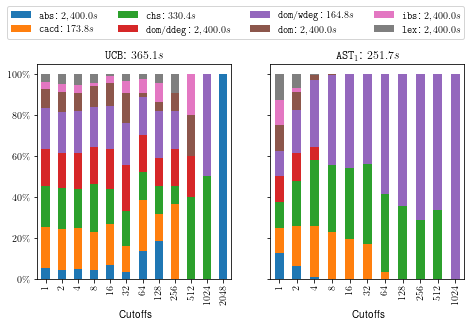

Primes-15-60-3-5


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


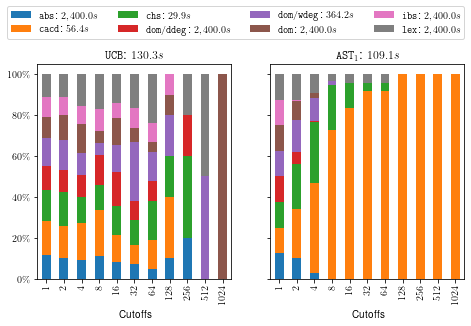

Rlfap-scen-11-f01_c18


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


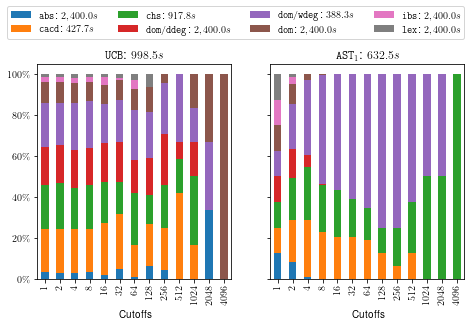

In [39]:
import matplotlib.ticker as mtick
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

for instance_name in analysis.inputs:
        
    print(instance_name)
    
    a2 = analysis.filter_analysis(
        lambda x: x.input == instance_name
    )

    if len(a2.experiment_wares) < 2 or True not in a2.data_frame.success.unique():
        continue

    a2.apply_on_groupby(
        by=['input', 'experiment_ware'],
        func=split_xp_by_run,
        inplace=True
    )

    a2.add_variable(
        'luby',
        lambda x: luby(x['run']),
        inplace=True
    )

    fig, ax = plt.subplots(1,2, sharey=True, figsize=(7.5,4))

    for i, sub in enumerate(a2.groupby('experiment_ware')):
        df = sub.data_frame
        title = df.experiment_ware.unique()[0]
        df = df.groupby(['luby', 'arm']).apply(lambda df: len(df)).to_frame().reset_index()
        df['arm'] = df.apply(lambda x: f'{MAP_NAME[x["arm"]]}: ${find(MAP_NAME_R[MAP_NAME[x["arm"]]], instance_name, analysis3):,.1f}s$', axis=1)

        df = df.pivot_table(
            index='arm',
            columns='luby',
            values=0,
        ).fillna(0)

        df = df.rename(columns={x: f'${x}$' for x in df.columns})

        (df / df.sum()).T.plot.bar(
            figsize=(7.65, 3.95),
            stacked=True, 
            ax=ax[i],
            legend=False,
            xlabel='Cutoffs',
            title=f'{MAP_NAME[title]}: ${find(title, instance_name, analysis3):,.1f}s$'
        )

        vals = ax[i].get_yticks()
        ax[i].set_yticklabels([f'${(i*100):.0f}\%$' for i in vals])

        handles, labels = ax[i].get_legend_handles_labels()

    fig.legend(
        handles, 
        labels, 
        loc='upper center', 
        ncol=4,
        bbox_to_anchor=(.485,1.1)
    )

    plt.savefig(
        f"fig/barplot_{instance_name}.pdf", 
        bbox_inches='tight', 
        transparent=True,
        pad_inches=.1
    )
    plt.show()